# Error analysis for Context-Aware ALD Models 

This notebook contrains the error and qualitative analysis for different models trained on CAD for Abusive Language Detection.

## Set up 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import json
import seaborn as sns
import os 
import csv

## Read output test file 

In [59]:
file_path = "../../modernbert-class_cad_eval_test_outputs.jsonl"


In [60]:
# Open the jsonl file and read it line by line
def get_error_stats(file_path):
    true_predictions, tp, tn, false_predictions, fp, fn = 0, 0, 0, 0, 0, 0
    model_pred_1, model_pred_0 = 0, 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Parse the JSON object from each line
            json_obj = json.loads(line.strip())
            if int(json_obj['pred_label']) == int(json_obj['y']):
                true_predictions += 1
                if int(json_obj['pred_label']) == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                false_predictions += 1
                if int(json_obj['pred_label']) == 1:
                    fp += 1
                else:
                    fn += 1
            
            if int(json_obj['pred_label']) == 1:
                model_pred_1 += 1
            else:
                model_pred_0 += 1

    return {
        "true_predictions": true_predictions,
        "true_positives": tp,
        "true_negatives": tn,
        "false_predictions": false_predictions,
        "false_positives": fp,
        "false_negatives": fn,
        "model_pred_1": model_pred_1,
        "model_pred_0": model_pred_0
    }



In [61]:
models = ["bert-class", "modernbert-class", "bert-concat", "bertwithneighconcat", "gat-test"]
stats_list = []

for model in models:
    file_path = os.path.join("../..", model + "_cad_eval_test_outputs.jsonl")
    print("Model: ", model)
    stats = get_error_stats(file_path)
    stats["model"] = model  # Add model name to the stats
    stats_list.append(stats)

# Write stats to a CSV file
output_file = "model_error_stats.csv"
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=[
        "model", "true_predictions", "true_positives", "true_negatives",
        "false_predictions", "false_positives", "false_negatives",
        "model_pred_1", "model_pred_0"
    ])
    writer.writeheader()
    writer.writerows(stats_list)

print(f"Stats written to {output_file}")

Model:  bert-class


FileNotFoundError: [Errno 2] No such file or directory: '../../bert-class_cad_eval_test_outputs.jsonl'

Get the correspondance between comment/post ids and graph files.

In [6]:
# output content of 100 first graph objetcs into the sample-reanno folder in data folder
graph_input_dir = "../../data/processed_graphs/processed/"
index_file = "../../data/cad-test-idx-many.txt"
output_file = "eval_set_output.csv"
output_dic = {}

def extract_info_from_graph(index_file, output_file):
    with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['filename', 'id', 'reddit_url', 'label', 'anno_ctx', 'anno_tgt', 'anno_tgt_cat', 'body', 'index_in_conv', 'conv_len']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        with open(index_file, "r") as file:
            indices = file.readlines()
            indices = [int(index.strip()) for index in indices]
            for index in indices:
                input_file = f"{graph_input_dir}graph-{index}.pt"
                try:
                    # Load the.pt file
                    graph = torch.load(input_file)
                    true_index = [i for i in range(len(graph.y_mask)) if graph.y_mask[i] == True]
                    assert len(true_index) == 1
                    true_index = true_index[0]

                    comment = graph.x_text[true_index]
                    x, a2, a3, label = comment
                    my_id = x.get('id', '')
                    permalink = x.get('permalink', '')
                    reddit_url = 'https://www.reddit.com' + permalink
                    
                    label = x.get('label', '')
                    anno_ctx = x.get('anno_ctx', '')
                    anno_tgt = x.get('anno_tgt', '')
                    anno_tgt_cat = x.get('anno_tgt_cat', '')
                    body = x.get('body', '')
                    
                    # Write to CSV
                    writer.writerow({
                        'filename': input_file,
                        'id': my_id,
                        'reddit_url': reddit_url,
                        'label': label,
                        'anno_ctx': anno_ctx,
                        'anno_tgt': anno_tgt,
                        'anno_tgt_cat': anno_tgt_cat,
                        'body': body,
                        'index_in_conv': true_index,
                        'conv_len': len(graph.y_mask)
                    })

                    #target_comment = graph.x_text[true_index]
                    #print(target_comment)


                except FileNotFoundError:
                    print(f"File {input_file} not found.")


extract_info_from_graph(index_file, output_file)


/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/2808701627.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(input_file)
/Users/celiano

## Check model errors

#### bot-gat-dir-3l-cad-512-7_3625338_eval_outputs

In [7]:
%pwd

'/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/notebooks'

In [ ]:
import json
import csv
import pandas as pd


def jsonl_to_csv(input_file, output_file):
    # Read the JSONL file and extract the data
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line.strip())
            obj['tp'], obj['tn'], obj['fp'], obj['fn'] = 0, 0, 0, 0
            if int(obj['pred_label']) == int(obj['y']):
                if int(obj['pred_label']) == 1:
                    obj['tp'] = 1
                else:
                    obj['tn'] = 1
            else:
                if int(obj['pred_label']) == 1:
                    obj['fp'] = 1
                else:
                    obj['fn'] = 1
            data.append(obj)

    # Flatten and normalize arrays or complex fields into strings
    def flatten_value(value):
        if isinstance(value, list):
            return ";".join(map(str, value))  # Join list elements with semicolons
        return value

    # Get all unique keys in the JSON objects (assuming consistent fields)
    if data:
        headers = data[0].keys()
    else:
        raise ValueError("The JSONL file is empty or malformed.")

    # Write to CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for item in data:
            flattened_item = {key: flatten_value(value) for key, value in item.items()}
            writer.writerow(flattened_item)

    print(f"Conversion complete! Data saved to {output_file}")

# Input JSONL file
input_file = "/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/longconcat-all-prep2-cad-4096-42(best)_outputs.jsonl"
# Output CSV file
output_file = "/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/longconcat-all-prep2-cad-4096-42(best)_outputs.csv"

# Convert JSONL to CSV
jsonl_to_csv(input_file, output_file)

In [9]:
import pandas as pd

# Create a DataFrame
bert_results = pd.read_csv("../bertclass-cad-512-123_3625347_eval_outputs.csv")
gat3l_results = pd.read_csv("../bot-gat-dir-3l-cad-512-7_3625338_eval_outputs.csv")
gat2l_results = pd.read_csv("../bot-gat-dir-2l-cad-512-7_3624560_eval_outputs.csv")
best_bert_results = pd.read_csv("../bertclass-cad-512-42(best)_eval_outputs.csv")
best_graph_results = pd.read_csv("../bot-gat-dir-3l-cad-512-42(best)_eval_outputs.csv")
best_longconcat_results = pd.read_csv("../longconcat-all-prep2-cad-4096-42(best)_outputs.csv")



In [10]:
best_graph_results["conv_indices_to_keep"] 

0          0;1;2;3;4;19;25;29;34;35;37;38
1      0;1;2;9;12;13;23;24;27;28;36;37;38
2        0;1;2;15;16;25;26;39;69;70;74;75
3            0;1;2;9;12;13;23;24;37;38;46
4                                     0;2
                      ...                
716                    0;2;3;7;8;12;14;15
717                 0;1;21;39;43;60;61;64
718                    0;2;3;4;7;10;11;14
719                  0;2;3;4;5;8;10;11;21
720                                 0;1;2
Name: conv_indices_to_keep, Length: 721, dtype: object

## Features of correct predictions VS model errors

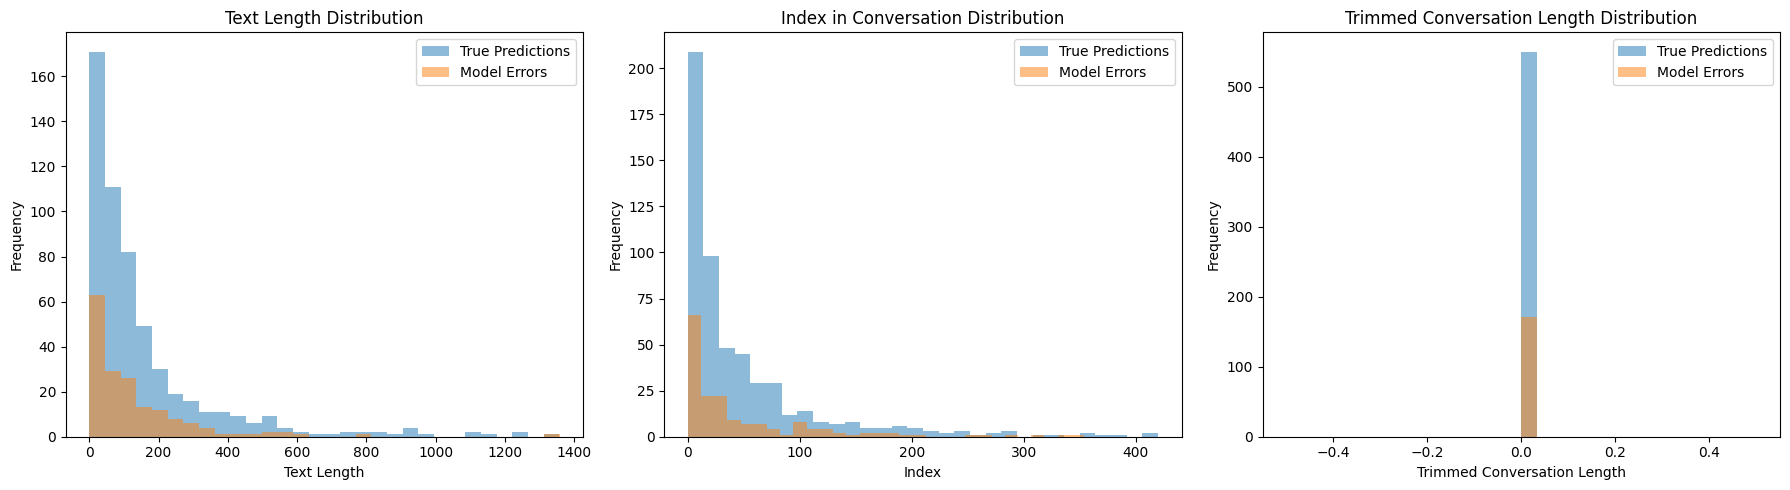

In [11]:


# Ensure conv_indices_to_keep is treated as a list
best_graph_results["conv_indices_to_keep"] = best_graph_results["conv_indices_to_keep"].apply(lambda x: x if isinstance(x, list) else [])

# Compute derived features, handling missing values
best_graph_results["text"] = best_graph_results["text"].fillna("")
best_graph_results["text_length"] = best_graph_results["text"].apply(len)
best_graph_results["trimmed_conv_length"] = best_graph_results["conv_indices_to_keep"].apply(len)

# Define true predictions and model errors
true_predictions = best_graph_results[(best_graph_results["tp"] == 1) | (best_graph_results["tn"] == 1)]
model_errors = best_graph_results[(best_graph_results["fp"] == 1) | (best_graph_results["fn"] == 1)]

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram 1: Length of text
axes[0].hist(true_predictions["text_length"], bins=30, alpha=0.5, label="True Predictions")
axes[0].hist(model_errors["text_length"], bins=30, alpha=0.5, label="Model Errors")
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Histogram 2: Index in conversation
axes[1].hist(true_predictions["index"], bins=30, alpha=0.5, label="True Predictions")
axes[1].hist(model_errors["index"], bins=30, alpha=0.5, label="Model Errors")
axes[1].set_title("Index in Conversation Distribution")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# Histogram 3: Length of trimmed conversation
axes[2].hist(true_predictions["trimmed_conv_length"], bins=30, alpha=0.5, label="True Predictions")
axes[2].hist(model_errors["trimmed_conv_length"], bins=30, alpha=0.5, label="Model Errors")
axes[2].set_title("Trimmed Conversation Length Distribution")
axes[2].set_xlabel("Trimmed Conversation Length")
axes[2].set_ylabel("Frequency")
axes[2].legend()

plt.tight_layout()
plt.show()


In [12]:
import scipy.stats as stats

def compute_mean_ci(data, confidence=0.95):
    mean = data.mean()
    sem = stats.sem(data)
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=sem) if len(data) > 1 else (mean, mean)
    return mean, ci[0], ci[1]

# Compute statistics for each variable
stats_table = pd.DataFrame({
    "Variable": ["Text Length", "Index in Conversation", "Trimmed Conversation Length"],
    "True Predictions Mean (CI)": [
        compute_mean_ci(true_predictions["text_length"]),
        compute_mean_ci(true_predictions["index"]),
        compute_mean_ci(true_predictions["trimmed_conv_length"])
    ],
    "Model Errors Mean (CI)": [
        compute_mean_ci(model_errors["text_length"]),
        compute_mean_ci(model_errors["index"]),
        compute_mean_ci(model_errors["trimmed_conv_length"])
    ]
})

# Format table for display
stats_table["True Predictions Mean (CI)"] = stats_table["True Predictions Mean (CI)"].apply(lambda x: f"{x[0]:.2f} ({x[1]:.2f} - {x[2]:.2f})")
stats_table["Model Errors Mean (CI)"] = stats_table["Model Errors Mean (CI)"].apply(lambda x: f"{x[0]:.2f} ({x[1]:.2f} - {x[2]:.2f})")

print(stats_table)


                      Variable True Predictions Mean (CI)  \
0                  Text Length   154.17 (137.22 - 171.12)   
1        Index in Conversation      48.32 (42.63 - 54.01)   
2  Trimmed Conversation Length           0.00 (nan - nan)   

     Model Errors Mean (CI)  
0  127.73 (102.84 - 152.62)  
1     47.73 (37.49 - 57.96)  
2          0.00 (nan - nan)  


/Users/celianouri/anaconda3/envs/hatedisc/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/celianouri/anaconda3/envs/hatedisc/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


## How does this model perform on context specific samples?

In [13]:
best_bert_results_ctx = best_bert_results[best_bert_results['anno_ctx'] == 'PreviousContent']
best_graph_results_ctx = best_graph_results[best_graph_results['anno_ctx'] == 'PreviousContent']
best_longconcat_results_ctx = best_longconcat_results[best_longconcat_results['anno_ctx'] == 'PreviousContent']

In [14]:
best_graph_results_ctx.head()

,id,reddit_url,index,text,anno_ctx,anno_tgt,anno_tgt_cat,label,y,pred_label,y_pred,texts,conv_indices_to_keep,tp,tn,fp,fn,text_length,trimmed_conv_length
3,etnmw0w,https://www.reddit.com/r/TumblrInAction/commen...,46,"Feminist, Feminism, *Funny, LOL*",PreviousContent,feminists,political affiliation,AffiliationDirectedAbuse,1.0,1,"[-1.8421907424926758, 1.8497545719146729]",;Normalise masturbation? What does this ever m...,[],1,0,0,0,32,0
17,eteyggm,https://www.reddit.com/r/Drama/comments/cbchrd...,74,Gypsies of peace strike again.,PreviousContent,romani people,ethnicity,IdentityDirectedAbuse,1.0,1,"[-2.5046000480651855, 2.482245445251465]",;Trumps concentration camps are open for busin...,[],1,0,0,0,30,0
18,eio7kct,https://www.reddit.com/r/4chan/comments/b1ta8a...,7,"The first guy was trying to run away, can clea...",PreviousContent,brenton tarrant,hateful entities,IdentityDirectedAbuse,1.0,1,"[-1.2868059873580933, 1.2466493844985962]",;>Shoots man bravely attempting to disarm him\...,[],1,0,0,0,317,0
23,efxvf7g,https://www.reddit.com/r/4chan/comments/anszg4...,136,I don't need a fucking weebs opinion,PreviousContent,NaN,NaN,PersonDirectedAbuse,1.0,1,"[-3.4599242210388184, 3.4274837970733643]",;Brazil? Gonna need an explanation for that on...,[],1,0,0,0,36,0
26,eofd2ju,https://www.reddit.com/r/conspiracy/comments/b...,2,Our responsibilities lol. The arrogance and en...,PreviousContent,people from america,nationality/origin,IdentityDirectedAbuse,1.0,1,"[-2.6680080890655518, 2.721731185913086]",;###[Meta] Sticky Comment\n\n[Rule 2](https://...,[],1,0,0,0,76,0


In [15]:
best_bert_results_ctx.head()

,id,reddit_url,index,text,anno_ctx,anno_tgt,anno_tgt_cat,label,y,pred_label,y_pred,x,masked_index,tp,tn,fp,fn
3,etnmw0w,https://www.reddit.com/r/TumblrInAction/commen...,46,"Feminist, Feminism, *Funny, LOL*",PreviousContent,feminists,political affiliation,AffiliationDirectedAbuse,1.0,1,"[-1.1428617238998413, 1.2060739994049072]","{'id': 'etnmw0w', 'name': 't1_etnmw0w', 'autho...",46,1,0,0,0
17,eteyggm,https://www.reddit.com/r/Drama/comments/cbchrd...,74,Gypsies of peace strike again.,PreviousContent,romani people,ethnicity,IdentityDirectedAbuse,1.0,1,"[-1.4758193492889404, 1.5208029747009277]","{'id': 'eteyggm', 'name': 't1_eteyggm', 'autho...",74,1,0,0,0
18,eio7kct,https://www.reddit.com/r/4chan/comments/b1ta8a...,7,"The first guy was trying to run away, can clea...",PreviousContent,brenton tarrant,hateful entities,IdentityDirectedAbuse,1.0,1,"[-0.03366149216890335, 0.3167352080345154]","{'id': 'eio7kct', 'name': 't1_eio7kct', 'autho...",7,1,0,0,0
23,efxvf7g,https://www.reddit.com/r/4chan/comments/anszg4...,136,I don't need a fucking weebs opinion,PreviousContent,NaN,NaN,PersonDirectedAbuse,1.0,1,"[-1.526110291481018, 1.7947399616241455]","{'id': 'efxvf7g', 'name': 't1_efxvf7g', 'autho...",136,1,0,0,0
26,eofd2ju,https://www.reddit.com/r/conspiracy/comments/b...,2,Our responsibilities lol. The arrogance and en...,PreviousContent,people from america,nationality/origin,IdentityDirectedAbuse,1.0,1,"[-1.7145277261734009, 1.851286768913269]","{'id': 'eofd2ju', 'name': 't1_eofd2ju', 'autho...",2,1,0,0,0


In [16]:
best_longconcat_results_ctx.head()

,id,reddit_url,index,text,anno_ctx,anno_tgt,anno_tgt_cat,label,y,pred_label,y_pred,x,masked_index,tp,tn,fp,fn
3,etnmw0w,https://www.reddit.com/r/TumblrInAction/commen...,46,"Feminist, Feminism, *Funny, LOL*",PreviousContent,feminists,political affiliation,AffiliationDirectedAbuse,1.0,0,"[0.4053743779659271, -0.3123070299625397]","{'id': 'etnmw0w', 'name': 't1_etnmw0w', 'autho...",46,0,0,0,1
17,eteyggm,https://www.reddit.com/r/Drama/comments/cbchrd...,74,Gypsies of peace strike again.,PreviousContent,romani people,ethnicity,IdentityDirectedAbuse,1.0,1,"[-1.276366949081421, 1.5308992862701416]","{'id': 'eteyggm', 'name': 't1_eteyggm', 'autho...",74,1,0,0,0
18,eio7kct,https://www.reddit.com/r/4chan/comments/b1ta8a...,7,"The first guy was trying to run away, can clea...",PreviousContent,brenton tarrant,hateful entities,IdentityDirectedAbuse,1.0,0,"[0.17314167320728302, -0.09322214126586914]","{'id': 'eio7kct', 'name': 't1_eio7kct', 'autho...",7,0,0,0,1
23,efxvf7g,https://www.reddit.com/r/4chan/comments/anszg4...,136,I don't need a fucking weebs opinion,PreviousContent,NaN,NaN,PersonDirectedAbuse,1.0,1,"[-1.8177295923233032, 1.8678799867630005]","{'id': 'efxvf7g', 'name': 't1_efxvf7g', 'autho...",136,1,0,0,0
26,eofd2ju,https://www.reddit.com/r/conspiracy/comments/b...,2,Our responsibilities lol. The arrogance and en...,PreviousContent,people from america,nationality/origin,IdentityDirectedAbuse,1.0,1,"[-2.272491216659546, 2.2856414318084717]","{'id': 'eofd2ju', 'name': 't1_eofd2ju', 'autho...",2,1,0,0,0


In [17]:
summary_ctx = best_bert_results_ctx[['tp', 'tn', 'fp', 'fn']].sum()
print("BERT model with best performance on context 'PreviousContent':")
print(summary_ctx)

best_bert_results_currctx = best_bert_results[best_bert_results['anno_ctx'] == 'CurrentContent']
summary_currctx = best_bert_results_currctx[['tp', 'tn', 'fp', 'fn']].sum()
print("BERT model with best performance on context 'CurrentContext':")
print(summary_currctx)

print(f"Best BERT model is wrong on {summary_ctx['fn']*100/(summary_ctx['fn'] + summary_ctx['tp'])} % of Previous Context cases.")
print(f"Best BERT model is wrong on {summary_currctx['fn']*100/(summary_currctx['fn'] + summary_currctx['tp'])} % of Current Context cases.")


BERT model with best performance on context 'PreviousContent':
tp    80
tn     2
fp     1
fn    30
dtype: int64
BERT model with best performance on context 'CurrentContext':
tp    201
tn      0
fp      2
fn     37
dtype: int64
Best BERT model is wrong on 27.272727272727273 % of Previous Context cases.
Best BERT model is wrong on 15.546218487394958 % of Current Context cases.


In [47]:
summary_ctx

tp    86
tn     1
fp     2
fn    24
dtype: int64

In [18]:
summary_ctx = best_graph_results_ctx[['tp', 'tn', 'fp', 'fn']].sum()
print("Graph model with best performance on context 'PreviousContent':")
print(summary_ctx)

best_graph_results_currctx = best_graph_results[best_graph_results['anno_ctx'] == 'CurrentContent']
summary_currctx = best_graph_results_currctx[['tp', 'tn', 'fp', 'fn']].sum()
print("Graph model with best performance on context 'CurrentContext':")
print(summary_currctx)

print(f"Best Graph model is wrong on {summary_ctx['fn']*100/(summary_ctx['fn'] + summary_ctx['tp'])} % of Previous Context cases.")
print(f"Best Graph model is wrong on {summary_currctx['fn']*100/(summary_currctx['fn'] + summary_currctx['tp'])} % of Current Context cases.")

Graph model with best performance on context 'PreviousContent':
tp    86
tn     2
fp     1
fn    24
dtype: int64
Graph model with best performance on context 'CurrentContext':
tp    206
tn      0
fp      2
fn     32
dtype: int64
Best Graph model is wrong on 21.818181818181817 % of Previous Context cases.
Best Graph model is wrong on 13.445378151260504 % of Current Context cases.


In [19]:
summary_ctx = best_longconcat_results_ctx[['tp', 'tn', 'fp', 'fn']].sum()
print("Longf concat with best performance on context 'PreviousContent':")
print(summary_ctx)

best_longconcat_results_currctx = best_longconcat_results[best_longconcat_results['anno_ctx'] == 'CurrentContent']
summary_currctx = best_longconcat_results_currctx[['tp', 'tn', 'fp', 'fn']].sum()
print("Best Longf concat model with best performance on context 'CurrentContext':")
print(summary_currctx)

print(f"Best Longf concat model is wrong on {summary_ctx['fn']*100/(summary_ctx['fn'] + summary_ctx['tp'])} % of Previous Context cases.")
print(f"Best Longf concat model is wrong on {summary_currctx['fn']*100/(summary_currctx['fn'] + summary_currctx['tp'])} % of Current Context cases.")

Longf concat with best performance on context 'PreviousContent':
tp    86
tn     1
fp     2
fn    24
dtype: int64
Best Longf concat model with best performance on context 'CurrentContext':
tp    204
tn      0
fp      2
fn     34
dtype: int64
Best Longf concat model is wrong on 21.818181818181817 % of Previous Context cases.
Best Longf concat model is wrong on 14.285714285714286 % of Current Context cases.


### Compute for 10 runs

In [50]:
import pandas as pd

# Generate fake data for 10 runs per model and context
bert_prev_results = pd.DataFrame({
    "tp": [80, 85, 78, 82, 83, 79, 81, 84, 80, 82],
    "tn": [2, 3, 2, 1, 2, 3, 2, 1, 2, 2],
    "fp": [1, 2, 1, 2, 1, 2, 1, 1, 2, 1],
    "fn": [30, 28, 32, 29, 27, 29, 30, 28, 31, 29]
})

bert_curr_results = pd.DataFrame({
    "tp": [201, 198, 203, 202, 200, 204, 199, 205, 202, 201],
    "tn": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "fp": [2, 1, 2, 2, 2, 1, 2, 1, 2, 2],
    "fn": [37, 39, 36, 35, 38, 34, 37, 36, 35, 38]
})

graph_prev_results = pd.DataFrame({
    "tp": [86, 88, 85, 87, 86, 89, 87, 85, 88, 86],
    "tn": [2, 2, 1, 2, 2, 2, 1, 1, 2, 2],
    "fp": [1, 1, 2, 1, 1, 1, 2, 2, 1, 1],
    "fn": [24, 22, 25, 23, 24, 21, 23, 25, 22, 24]
})

graph_curr_results = pd.DataFrame({
    "tp": [206, 204, 205, 207, 203, 208, 206, 204, 205, 207],
    "tn": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "fp": [2, 1, 2, 1, 2, 1, 2, 1, 2, 2],
    "fn": [32, 34, 33, 31, 35, 30, 32, 34, 33, 31]
})

longf_prev_results = pd.DataFrame({
    "tp": [86, 87, 85, 88, 86, 89, 88, 86, 87, 85],
    "tn": [1, 1, 2, 1, 1, 1, 2, 2, 1, 1],
    "fp": [2, 1, 2, 2, 1, 2, 1, 2, 1, 2],
    "fn": [24, 23, 26, 22, 24, 21, 23, 26, 22, 24]
})

longf_curr_results = pd.DataFrame({
    "tp": [204, 203, 205, 206, 202, 207, 204, 203, 205, 206],
    "tn": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "fp": [2, 1, 2, 2, 1, 2, 2, 1, 2, 2],
    "fn": [34, 35, 33, 32, 36, 31, 34, 35, 33, 32]
})


In [2]:
import json
import csv
import pandas as pd


def jsonl_to_csv(input_file, output_file):
    # Read the JSONL file and extract the data
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line.strip())
            obj['tp'], obj['tn'], obj['fp'], obj['fn'] = 0, 0, 0, 0
            if int(obj['pred_label']) == int(obj['y']):
                if int(obj['pred_label']) == 1:
                    obj['tp'] = 1
                else:
                    obj['tn'] = 1
            else:
                if int(obj['pred_label']) == 1:
                    obj['fp'] = 1
                else:
                    obj['fn'] = 1
            data.append(obj)

    # Flatten and normalize arrays or complex fields into strings
    def flatten_value(value):
        if isinstance(value, list):
            return ";".join(map(str, value))  # Join list elements with semicolons
        return value

    # Get all unique keys in the JSON objects (assuming consistent fields)
    if data:
        headers = data[0].keys()
    else:
        raise ValueError("The JSONL file is empty or malformed.")

    # Write to CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for item in data:
            flattened_item = {key: flatten_value(value) for key, value in item.items()}
            writer.writerow(flattened_item)

    print(f"Conversion complete! Data saved to {output_file}")

# Input JSONL file
input_file = "/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/longconcat-all-prep2-cad-4096-42(best)_outputs.jsonl"
# Output CSV file
output_file = "/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/longconcat-all-prep2-cad-4096-42(best)_outputs.csv"

# Convert JSONL to CSV
#jsonl_to_csv(input_file, output_file)

dataframes = {}

#filenames = ["bert-class-cad-512-99_3633771", "bert-class-cad-512-2025_3633770", "bertclass-cad-512-3_3639137", "bertclass-cad-512-7_3625346", "bertclass-cad-512-39_3638271", "bertclass-cad-512-42_3625345", "bertclass-cad-512-123_3625347", "bertclass-cad-512-762_3638789", "bertclass-cad-512-1801_3638272", "bertclass-cad-512-4504_3639136"]
filenames = [
        "longconcat-all-prep2-cad-4096-7_3628033",
        "longconcat-all-prep2-cad-4096-99_3632139",
        "longconcat-all-prep2-cad-4096-2025_3632138",
        "longconcat-cad-512-39_3639138",
        "longconcat-cad-512-39_3639142",
        "longconcat-cad-512-42_3870987",
        "longconcat-cad-512-762_3639140",
        "longconcat-cad-512-1801_3639141",
        "longconcat-cad-512-4504_3639139",
        "longconcat-cad-4096-3_3896046"
    ]

filenames = [
        "bot-gat-dir-3l-cad-512-3_3638744",
        "bot-gat-dir-3l-cad-512-7_3625338",
        #"bot-gat-dir-3l-cad-512-39_3638267",
        "bot-gat-dir-3l-cad-512-39_3896130",
        "bot-gat-dir-3l-cad-512-42_3625337",
        "bot-gat-dir-3l-cad-512-99_3634179",
        "bot-gat-dir-3l-cad-512-123_3625340",
        "bot-gat-dir-3l-cad-512-762_3638741",
        "bot-gat-dir-3l-cad-512-1801_3638740",
        "bot-gat-dir-3l-cad-512-2025_3634181",
        "bot-gat-dir-3l-cad-512-4504_3638742",
    ]

filenames = [
        "bert-ctxemb-new-42_3906329",
        "bert-ctxemb-new-7_3906282",
        "bert-ctxemb-new-123_3906052",
        "bert-ctxemb-new-2025_3906051",
        "bert-ctxemb-new-99_3905942",
        "bert-ctxemb-39_3905658",
        "bert-ctxemb-1801_3905484",
        "bert-ctxemb-762_3904206",
        "bert-ctxemb-4504_3904204",
        "bert-ctxemb-3_3904201",    
]
for filename in filenames:
    input_file = f"/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/{filename}.tsv"
    output_file = f"/Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/{filename}.csv"
    jsonl_to_csv(input_file, output_file)
    dataframe = pd.read_csv(output_file)
    dataframes[filename] = dataframe

dataframes 

Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-new-42_3906329.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-new-7_3906282.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-new-123_3906052.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-new-2025_3906051.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-new-99_3905942.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-39_3905658.csv
Conversion complete! Data saved to /Users/celianouri/Stage24/HatefulDiscussionsModeling/model_hateful_comments/bert-ctxemb-1801_3905484.csv
Conversion

{'bert-ctxemb-new-42_3906329':           id                                         reddit_url  index  \
 0    el5eh5l  https://www.reddit.com/r/TumblrInAction/commen...      4   
 1    etotgus  https://www.reddit.com/r/TumblrInAction/commen...     36   
 2    ep0yt9p  https://www.reddit.com/r/TumblrInAction/commen...     39   
 3    etnmw0w  https://www.reddit.com/r/TumblrInAction/commen...     46   
 4    emzvb9e  https://www.reddit.com/r/CCJ2/comments/bmuhp3/...      2   
 ..       ...                                                ...    ...   
 716  eljrdq6  https://www.reddit.com/r/SubredditDrama/commen...      8   
 717  ejz4tkx  https://www.reddit.com/r/ShitPoliticsSays/comm...     61   
 718  ejuajmp  https://www.reddit.com/r/conspiracy/comments/b...     14   
 719  eu7xahk  https://www.reddit.com/r/Negareddit/comments/c...     11   
 720  ervzrej  https://www.reddit.com/r/subredditcancer/comme...      2   
 
                                                   text         anno

In [3]:

# Initialize dictionaries to store results
prev_context_data = {}
curr_context_data = {}

for name in dataframes.keys():
    df = dataframes[name]
    dataframe_prev_context = df[df['anno_ctx'] == 'PreviousContent']
    prev_context_sum =  dataframe_prev_context[['tp', 'tn', 'fp', 'fn']].sum()
    prev_context_data[name] = prev_context_sum

    dataframe_curr_context = df[df['anno_ctx'] == 'CurrentContent']
    curr_context_sum =  dataframe_curr_context[['tp', 'tn', 'fp', 'fn']].sum()
    curr_context_data[name] = curr_context_sum
    
    # Convert the dictionaries into DataFrames
df_prev_context = pd.DataFrame.from_dict(prev_context_data, orient='index').reset_index()
df_prev_context.rename(columns={'index': 'Run'}, inplace=True)

df_curr_context = pd.DataFrame.from_dict(curr_context_data, orient='index').reset_index()
df_curr_context.rename(columns={'index': 'Run'}, inplace=True)

# Display the DataFrames
print(df_prev_context)
print(df_curr_context)

                            Run  tp  tn  fp  fn
0    bert-ctxemb-new-42_3906329  79   2   1  31
1     bert-ctxemb-new-7_3906282  80   2   1  30
2   bert-ctxemb-new-123_3906052  79   2   1  31
3  bert-ctxemb-new-2025_3906051  82   2   1  28
4    bert-ctxemb-new-99_3905942  78   2   1  32
5        bert-ctxemb-39_3905658  77   2   1  33
6      bert-ctxemb-1801_3905484  76   2   1  34
7       bert-ctxemb-762_3904206  77   2   1  33
8      bert-ctxemb-4504_3904204  78   2   1  32
9         bert-ctxemb-3_3904201  76   2   1  34
                            Run   tp  tn  fp  fn
0    bert-ctxemb-new-42_3906329  199   0   2  39
1     bert-ctxemb-new-7_3906282  212   0   2  26
2   bert-ctxemb-new-123_3906052  205   1   1  33
3  bert-ctxemb-new-2025_3906051  203   1   1  35
4    bert-ctxemb-new-99_3905942  198   1   1  40
5        bert-ctxemb-39_3905658  197   1   1  41
6      bert-ctxemb-1801_3905484  191   0   2  47
7       bert-ctxemb-762_3904206  197   1   1  41
8      bert-ctxemb-4504_3904204

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as st

def compute_mean_ci(df):
    """
    Compute mean and 95% confidence interval for correct and error percentages.

    Args:
        df (pd.DataFrame): DataFrame containing 'tp', 'tn', 'fp', 'fn' for 10 runs.

    Returns:
        dict: Mean ± CI for correct predictions and errors.
    """
    # Compute total cases per run
    total_cases = df[['tp', 'tn', 'fp', 'fn']].sum(axis=1)

    # Compute correct and error percentages
    correct_percentage = (df['tp'] + df['tn']) / total_cases * 100
    error_percentage = (df['fp'] + df['fn']) / total_cases * 100

    # Compute mean and 95% confidence interval (CI)
    mean_correct = np.mean(correct_percentage)
    mean_error = np.mean(error_percentage)

    ci_correct = st.t.interval(0.95, len(correct_percentage) - 1, loc=mean_correct, scale=st.sem(correct_percentage))
    ci_error = st.t.interval(0.95, len(error_percentage) - 1, loc=mean_error, scale=st.sem(error_percentage))

    return {
        'Mean Correct (%)': f"{mean_correct:.2f} ± {ci_correct[1] - mean_correct:.2f}",
        'Mean Error (%)': f"{mean_error:.2f} ± {ci_error[1] - mean_error:.2f}"
    }




In [5]:
# Compute results
prev_results = compute_mean_ci(df_prev_context)
curr_results = compute_mean_ci(df_curr_context)


# Print Results
print("Previous Context:")
print(f"{name}: {prev_results}")

print("\nCurrent Context:")
print(f"{name}: {curr_results}")


Previous Context:
bert-ctxemb-3_3904201: {'Mean Correct (%)': '70.97 ± 1.19', 'Mean Error (%)': '29.03 ± 1.19'}

Current Context:
bert-ctxemb-3_3904201: {'Mean Correct (%)': '83.00 ± 1.98', 'Mean Error (%)': '17.00 ± 1.98'}


In [ ]:
# Compute results
bert_prev_results = compute_mean_ci(bert_prev_results)
bert_curr_results = compute_mean_ci(bert_curr_results)

graph_prev_results = compute_mean_ci(graph_prev_results)
graph_curr_results = compute_mean_ci(graph_curr_results)

longf_prev_results = compute_mean_ci(longf_prev_results)
longf_curr_results = compute_mean_ci(longf_curr_results)

# Print Results
print("Previous Context:")
print("BERT:", bert_prev_results)
print("Graph Model:", graph_prev_results)
print("Longformer Concat:", longf_prev_results)

print("\nCurrent Context:")
print("BERT:", bert_curr_results)
print("Graph Model:", graph_curr_results)
print("Longformer Concat:", longf_curr_results)

### Model error analysis

In [20]:
bert_errors = bert_results[(bert_results["fp"] == 1) | (bert_results["fn"] == 1)]
gat3l_errors = gat3l_results[(gat3l_results["fp"] == 1) | (gat3l_results["fn"] == 1)]
gat2l_errors = gat2l_results[(gat2l_results["fp"] == 1) | (gat2l_results["fn"] == 1)]
best_bert_errors = best_bert_results[(best_bert_results["fp"] == 1) | (best_bert_results["fn"] == 1)]
best_graph_errors = best_graph_results[(best_graph_results["fp"] == 1) | (best_graph_results["fn"] == 1)]
best_longconcat_errors = best_longconcat_results[(best_longconcat_results["fp"] == 1) | (best_longconcat_results["fn"] == 1)]


In [21]:
best_bert_errors["model"] = "bert no context"
best_graph_errors["model"] = "Best graph model (3l)"
best_longconcat_errors["model"] = "Longf concat model"

/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/1075282744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_bert_errors["model"] = "bert no context"
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/1075282744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_graph_errors["model"] = "Best graph model (3l)"
/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/1075282744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [22]:
print("Best BERT model errors: false positives and false negatives")
summary_err = best_bert_errors[['fp', 'fn']].sum()
summary_truepreds = bert_results[['tp', 'tn']].sum()
print(summary_err)
print(summary_truepreds)

print("Best Graph model errors: false positives and false negatives")
summary_err = best_graph_errors[['fp', 'fn']].sum()
summary_truepreds = gat3l_results[['tp', 'tn']].sum()
print(summary_err)
print(summary_truepreds)

print("Best Longf concat model errors: false positives and false negatives")
summary_err = best_longconcat_errors[['fp', 'fn']].sum()
summary_truepreds = best_longconcat_results[['tp', 'tn']].sum()
print(summary_err)
print(summary_truepreds)

Best BERT model errors: false positives and false negatives
fp    112
fn     68
dtype: int64
tp    260
tn    275
dtype: int64
Best Graph model errors: false positives and false negatives
fp    114
fn     57
dtype: int64
tp    287
tn    255
dtype: int64
Best Longf concat model errors: false positives and false negatives
fp    118
fn     59
dtype: int64
tp    291
tn    253
dtype: int64


In [23]:

# Merge and compare BERT and Best Graph errors

merged_df = best_graph_errors.merge(best_bert_errors, on='id', how='outer', indicator=True)

# Compute statistics
unique_in_graph = (merged_df['_merge'] == 'left_only').sum()
unique_in_bert = (merged_df['_merge'] == 'right_only').sum()
unique_in_both = (merged_df['_merge'] == 'both').sum()
total_in_graph = gat3l_errors['id'].nunique()
total_in_bert = best_bert_errors['id'].nunique()

# Print results
print("Number of unique IDs in GAT 3l errors:", unique_in_graph)
print("Number of unique IDs in BERT no context errors:", unique_in_bert)
print("Number of unique IDs that are errors for both models:", unique_in_both)
print("Number of errors for GAT 3l:", total_in_graph)
print("Number of errors for BERT no context:", total_in_bert)

graph_only_err = merged_df[(merged_df['_merge'] == 'left_only')]
bert_only_err = merged_df[(merged_df['_merge'] == 'right_only')]


# Save rows_only_in_df1 as a CSV file
#unique_in_gat3l.to_csv('errors_for_gat3l_but_not_bert.csv', index=False)

# Save rows_only_in_df2 as a CSV file
#unique_in_bert.to_csv('errors_for_bert_but_not_gat3l.csv', index=False)

Number of unique IDs in GAT 3l errors: 31
Number of unique IDs in BERT no context errors: 40
Number of unique IDs that are errors for both models: 140
Number of errors for GAT 3l: 179
Number of errors for BERT no context: 180


In [24]:
# Errors that were solved by the Graph model over BERT
solved_by_graph = merged_df[(merged_df['_merge'] == 'right_only')]

print("Number of errors solved by the Graph model over BERT no context:", len(solved_by_graph))

Number of errors solved by the Graph model over BERT no context: 40


In [25]:
# Errors that remain errors for both models
errors_in_both = merged_df[(merged_df['_merge'] == 'both')]

print("Number of errors that remain errors for both models:", len(errors_in_both))

Number of errors that remain errors for both models: 140


In [26]:
# Save rows_only_in_df1 as a CSV file
solved_by_graph.to_csv('solved_by_graph(_over_bert_noctxt).csv', index=False)

# Save rows_only_in_df2 as a CSV file
#unique_in_bert.to_csv('errors_for_bert_but_not_gat3l.csv', index=False)

In [27]:

# Merge and compare Longf concat and Best Graph model errors

merged_df = best_graph_errors.merge(best_longconcat_errors, on='id', how='outer', indicator=True)

# Compute statistics
unique_in_graph = (merged_df['_merge'] == 'left_only').sum()
unique_in_longfconcat = (merged_df['_merge'] == 'right_only').sum()
unique_in_both = (merged_df['_merge'] == 'both').sum()
total_in_graph = gat3l_errors['id'].nunique()
total_in_longfconcat = best_longconcat_errors['id'].nunique()

# Print results
print("Number of unique IDs in GAT 3l errors:", unique_in_graph)
print("Number of unique IDs in Long concat errors:", unique_in_bert)
print("Number of unique IDs that are errors for both models:", unique_in_both)
print("Number of errors for GAT 3l:", total_in_graph)
print("Number of errors for  Long concat :", total_in_longfconcat)

graph_only_err = merged_df[(merged_df['_merge'] == 'left_only')]
longconcat_only_err = merged_df[(merged_df['_merge'] == 'right_only')]


# Save rows_only_in_df1 as a CSV file
#unique_in_gat3l.to_csv('errors_for_gat3l_but_not_bert.csv', index=False)

# Save rows_only_in_df2 as a CSV file
#unique_in_bert.to_csv('errors_for_bert_but_not_gat3l.csv', index=False)

Number of unique IDs in GAT 3l errors: 71
Number of unique IDs in Long concat errors: 40
Number of unique IDs that are errors for both models: 100
Number of errors for GAT 3l: 179
Number of errors for  Long concat : 177


In [28]:
# Errors that were solved by the Graph model over BERT
solved_by_graph = merged_df[(merged_df['_merge'] == 'right_only')]

print("Number of errors solved by the Graph model over Longf concat:", len(solved_by_graph))

Number of errors solved by the Graph model over Longf concat: 77


In [29]:
# Errors that remain errors for both models
errors_in_both = merged_df[(merged_df['_merge'] == 'both')]

print("Number of errors that remain errors for both models:", len(errors_in_both))

Number of errors that remain errors for both models: 100


In [30]:
# Save rows_only_in_df1 as a CSV file
solved_by_graph.to_csv('solved_by_graph(_over_longconcat).csv', index=False)

# Save rows_only_in_df2 as a CSV file
#unique_in_bert.to_csv('errors_for_longconcat_but_not_gat3l.csv', index=False)

#### Older code for old bert and old gat 3l models


In [31]:
gat3l_errors["model"] = "gat 3l"

/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/1910911973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gat3l_errors["model"] = "gat 3l"


In [32]:
gat2l_errors["model"] = "gat 2l"

/var/folders/r7/0255tsrx2dscctsn_23l9c300000gn/T/ipykernel_5213/3368721764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gat2l_errors["model"] = "gat 2l"


In [33]:

# Merge with an indicator column
merged_df = gat3l_errors.merge(bert_errors, on='id', how='outer', indicator=True)

# Compute statistics
unique_in_gat3l = (merged_df['_merge'] == 'left_only').sum()
unique_in_bert = (merged_df['_merge'] == 'right_only').sum()
unique_in_both = (merged_df['_merge'] == 'both').sum()
total_in_gat3l = gat3l_errors['id'].nunique()
total_in_bert = bert_errors['id'].nunique()

# Print results
print("Number of unique IDs in GAT 3l errors:", unique_in_gat3l)
print("Number of unique IDs in BERT no context errors:", unique_in_bert)
print("Number of unique IDs that are errors for both models:", unique_in_both)
print("Number of errors for GAT 3l:", total_in_gat3l)
print("Number of errors for BERT no context:", total_in_bert)


Number of unique IDs in GAT 3l errors: 38
Number of unique IDs in BERT no context errors: 45
Number of unique IDs that are errors for both models: 141
Number of errors for GAT 3l: 179
Number of errors for BERT no context: 186


In [34]:
unique_in_gat3l = merged_df[(merged_df['_merge'] == 'left_only')]
unique_in_bert = merged_df[(merged_df['_merge'] == 'right_only')]


# Save rows_only_in_df1 as a CSV file
unique_in_gat3l.to_csv('errors_for_gat3l_but_not_bert.csv', index=False)

# Save rows_only_in_df2 as a CSV file
unique_in_bert.to_csv('errors_for_bert_but_not_gat3l.csv', index=False)

### Context boolean 

In [35]:
bert_errors = bert_results[(bert_results["fp"] == 1) | (bert_results["fn"] == 1)]
gat3l_errors = gat3l_results[(gat3l_results["fp"] == 1) | (gat3l_results["fn"] == 1)]
gat2l_errors = gat2l_results[(gat2l_results["fp"] == 1) | (gat2l_results["fn"] == 1)]

In [36]:
# Group by context_boolean and sum up the fp, fn, tp, and tn columns
summary_bert = bert_results.groupby('anno_ctx')[['fp', 'fn', 'tp', 'tn']].sum().reset_index()
summary_gat3l = gat3l_results.groupby('anno_ctx')[['fp', 'fn', 'tp', 'tn']].sum().reset_index()

# Display the summary tables
print("Summary for BERT:")
print(summary_bert)

print("\nSummary for GAT 3l :")
print(summary_gat3l)

Summary for BERT:
          anno_ctx  fp  fn   tp  tn
0   CurrentContent   2  51  187   0
1  PreviousContent   1  38   72   2

Summary for GAT 3l :
          anno_ctx  fp  fn   tp  tn
0   CurrentContent   2  34  204   0
1  PreviousContent   1  28   82   2


### Results and IC

#### n = 10

In [87]:
# Third set of F1 scores
f1_scores= {
    "BERT (No Context)" : np.array([0.75806, 0.75497, 0.73654, 0.75632, 0.72859, 0.75335, 0.74348, 0.74646, 0.72931, 0.74545]),
    "Longf Concat":  np.array([0.75853, 0.73727, 0.72149, 0.7358, 0.75098, 0.73973, 0.73446, 0.75862, 0.73768, 0.74293]), 
    "Bert Embed Concat":  np.array([0.74863, 0.75332, 0.75668, 0.74868, 0.74896, 0.74722, 0.74548, 0.74722, 0.7459, 0.74548]), 
    "GAT 1l": np.array([0.75034, 0.74929, 0.75033, 0.73741, 0.75493, 0.76139, 0.75754, 0.75754, 0.74526, 0.77337]), 
    "GAT 2l": np.array([0.76533, 0.76501, 0.74834, 0.76294, 0.75683, 0.76216, 0.76267, 0.76731, 0.75603, 0.76613]),
    "GAT 3l": np.array([0.77411, 0.76228, 0.75275, 0.75467, 0.7655, 0.7623, 0.75574, 0.75591, 0.76398, 0.77692]),
    "GAT 4l": np.array([0.76075, 0.76319, 0.74716, 0.76883, 0.74967, 0.74412, 0.75936, 0.76964, 0.7609, 0.76818]),
    "GAT 5l": np.array([0.75204, 0.76115, 0.76862, 0.76658, 0.75593, 0.75196, 0.76776, 0.75995, 0.76364, 0.76164]),
}

model_names, mean_f1_scores, stds, conf_ints, ci_lowers, ci_uppers  = [], [], [], [], [], []

n = 10
t = 2.228 # t value for n=10 and a 95% confidence interval 


for model, f1s in f1_scores.items():
    model_names.append(model)
    mean_f1 = np.mean(f1s)
    mean_f1_scores.append(mean_f1)

    # Compute standard deviation
    std_ = np.std(f1s, ddof=1)
    stds.append(std_)

    # Compute confidence interval
    conf = t * (std_ / np.sqrt(n))
    conf_ints.append(conf)
    ci_lowers.append(mean_f1 - conf)
    ci_uppers.append(mean_f1 + conf)

# Create a DataFrame
df_n10 = pd.DataFrame({
    'Model Name': model_names,
    'Mean F1': mean_f1_scores,
    'Standard Deviation': stds,
    'Confidence Interval': conf_ints,
    'Confidence Interval Lower': ci_lowers,
    'Confidence Interval Upper': ci_uppers,
})


In [88]:
df_n10

,Model Name,Mean F1,Standard Deviation,Confidence Interval,Confidence Interval Lower,Confidence Interval Upper
0,BERT (No Context),0.745253,0.010847,0.007642,0.737611,0.752895
1,Longf Concat,0.741749,0.011511,0.008110,0.733639,0.749859
2,Bert Embed Concat,0.748757,0.003621,0.002551,0.746206,0.751308
3,GAT 1l,0.753740,0.009751,0.006870,0.746870,0.760610
4,GAT 2l,0.761275,0.005873,0.004138,0.757137,0.765413
5,GAT 3l,0.762416,0.008161,0.005750,0.756666,0.768166
6,GAT 4l,0.759180,0.009230,0.006503,0.752677,0.765683
7,GAT 5l,0.760927,0.006065,0.004273,0.756654,0.765200
